## OBJECTIVE

Clustering Analysis: 

Pincode Analysis excel contains data related to ecommerce site. First column is pincode in encrypted format, which you can replace with valid 6 digit numeric pincodes. Each row is unique on Pincode, so you need to add unique pin codes in each of the rows. Last columns total_orders is the number of orders placed/delivered in the corresponding pincode in a given time frame. All other columns are various categories of products sold in these orders. Numbers in each of these categories are %of total orders, so if you add up all the columns in a row, except first(pincode) and last(total_orders) it adds up to 100%. The task is to find if any categories are dominant in any pincode, or across few pin codes or all categories are spread uniformly across all pin codes. So business problem is to figure out if there is any category affinity towards any geographical area(pincode).

In [1]:
! pip install kneed
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans
from kneed import KneeLocator
import joblib
from sklearn.metrics import silhouette_score
from geopy.geocoders import Nominatim

### DATA EXPLORATION

In [2]:
df = pd.read_excel('/kaggle/input/pincode-analysis-xlsx/Pincode Analysis.xlsx')
df

,DAC49DE9MyETlKVkFxtZrPJu26RqezfY7+JccDvV,Agriculture,Appliances,BPC,Electronics,F&B,Fashion,Grocery,Health & Wellness,Home & Kitchen,Multi Category,Others,Undefined,total_orders
0,85A6B3EEMyETlKVkFxuy1z709sCcgQ==,NaN,0.446789,0.513025,0.210618,9.234456,2.274875,85.610235,0.471348,1.165471,0.018606,0.029521,0.025056,403099
1,914EC099MyETlKVkFxtbgaaUnW5FQw==,NaN,0.129535,0.126827,0.064993,0.115543,0.487900,98.737148,0.117800,0.209874,0.004062,0.004965,0.001354,221562
2,87404181MyETlKVkFxs0XoE03yRciA==,NaN,0.496763,0.847896,0.236457,72.982504,2.554345,20.691510,0.590128,1.382208,0.182163,0.025878,0.010148,197076
3,F9D55206MyETlKVkFxtrzbWIZlmuvg==,0.001344,0.931189,1.182462,0.487766,49.773585,5.216941,38.597976,1.011139,2.650462,0.049045,0.054420,0.043670,148842
4,135A7354MyETlKVkFxtAzxP199AV9g==,NaN,0.473075,0.820798,0.200907,57.399203,3.096882,35.344976,0.613023,1.744625,0.261007,0.018030,0.027474,116472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,4BB912A3MyETlKVkFxv4HxtbbibB1Q==,NaN,2.043040,2.402615,0.915282,69.125579,9.169164,9.267230,1.765187,5.088532,0.103514,0.087170,0.032689,18355
143,1AD03B94MyETlKVkFxuvbDV/UcKmqw==,NaN,0.404526,0.634122,0.235063,20.543377,3.083147,72.322746,0.453725,2.279560,0.021866,0.021866,NaN,18293
144,1D20DDE3MyETlKVkFxthlSEtwisn/Q==,NaN,0.936012,1.138541,0.470743,29.032788,4.280475,60.966665,0.738957,2.238765,0.076633,0.098528,0.021895,18269
145,580D9354MyETlKVkFxtyRg1ZhQ5KnA==,0.126186,4.822516,6.814067,2.084819,3.818511,19.388819,46.913919,4.147693,11.499424,0.148132,0.230427,0.005486,18227


In [3]:
# Replacing with valid 6 digit numeric pincodes
df.rename(columns={'DAC49DE9MyETlKVkFxtZrPJu26RqezfY7+JccDvV': 'pincode'}, inplace=True)
random.seed(100)
generated_pins = set()
def generate_unique_pin():
    while True:
        pin = random.randint(111111, 999999)
        if pin not in generated_pins:
            generated_pins.add(pin)
            return pin

df['pincode'] = df['pincode'].apply(lambda pin: random.randint(111111,999999))
df

,pincode,Agriculture,Appliances,BPC,Electronics,F&B,Fashion,Grocery,Health & Wellness,Home & Kitchen,Multi Category,Others,Undefined,total_orders
0,263856,NaN,0.446789,0.513025,0.210618,9.234456,2.274875,85.610235,0.471348,1.165471,0.018606,0.029521,0.025056,403099
1,592961,NaN,0.129535,0.126827,0.064993,0.115543,0.487900,98.737148,0.117800,0.209874,0.004062,0.004965,0.001354,221562
2,588136,NaN,0.496763,0.847896,0.236457,72.982504,2.554345,20.691510,0.590128,1.382208,0.182163,0.025878,0.010148,197076
3,919336,0.001344,0.931189,1.182462,0.487766,49.773585,5.216941,38.597976,1.011139,2.650462,0.049045,0.054420,0.043670,148842
4,294347,NaN,0.473075,0.820798,0.200907,57.399203,3.096882,35.344976,0.613023,1.744625,0.261007,0.018030,0.027474,116472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,609726,NaN,2.043040,2.402615,0.915282,69.125579,9.169164,9.267230,1.765187,5.088532,0.103514,0.087170,0.032689,18355
143,313306,NaN,0.404526,0.634122,0.235063,20.543377,3.083147,72.322746,0.453725,2.279560,0.021866,0.021866,NaN,18293
144,973109,NaN,0.936012,1.138541,0.470743,29.032788,4.280475,60.966665,0.738957,2.238765,0.076633,0.098528,0.021895,18269
145,661910,0.126186,4.822516,6.814067,2.084819,3.818511,19.388819,46.913919,4.147693,11.499424,0.148132,0.230427,0.005486,18227


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pincode            147 non-null    int64  
 1   Agriculture        5 non-null      float64
 2   Appliances         147 non-null    float64
 3   BPC                147 non-null    float64
 4   Electronics        147 non-null    float64
 5   F&B                147 non-null    float64
 6   Fashion            147 non-null    float64
 7   Grocery            147 non-null    float64
 8   Health & Wellness  147 non-null    float64
 9   Home & Kitchen     147 non-null    float64
 10  Multi Category     142 non-null    float64
 11  Others             147 non-null    float64
 12  Undefined          133 non-null    float64
 13  total_orders       147 non-null    int64  
dtypes: float64(12), int64(2)
memory usage: 16.2 KB


## Data Cleaning

In [5]:
#Checking for null values
df.isnull().sum()

pincode                0
Agriculture          142
Appliances             0
BPC                    0
Electronics            0
F&B                    0
Fashion                0
Grocery                0
Health & Wellness      0
Home & Kitchen         0
Multi Category         5
Others                 0
Undefined             14
total_orders           0
dtype: int64

<Axes: >

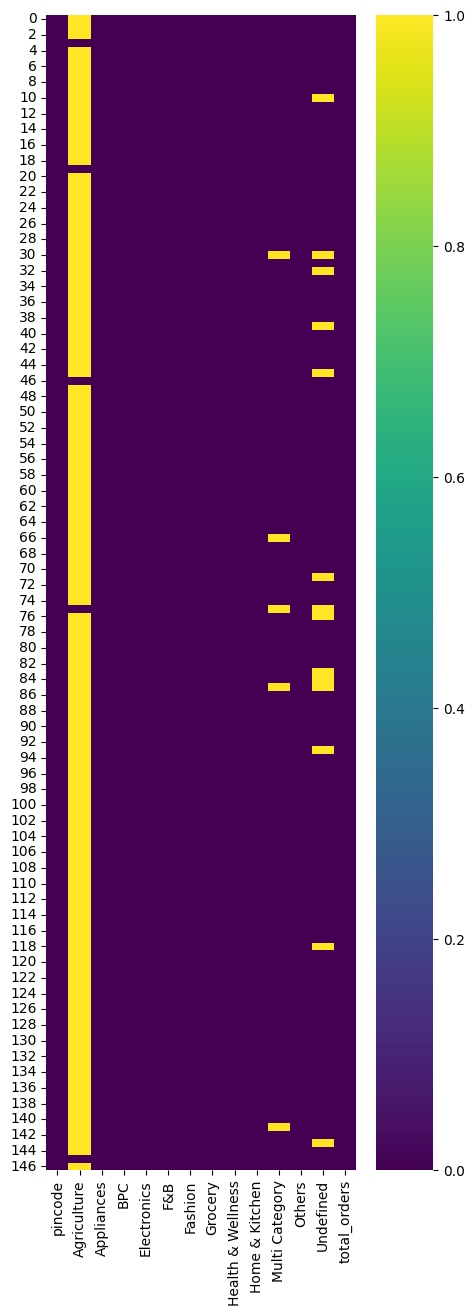

In [6]:
#Plotting heatmap  to visulize the missing values
plt.figure(figsize=(5, 15))
sns.heatmap(df.isnull(),cmap = 'viridis')

In [7]:
# Imputing Null values in 'Agriculture' with 0
df['Agriculture'] = df['Agriculture'].fillna(0)
df['Agriculture']

0      0.000000
1      0.000000
2      0.000000
3      0.001344
4      0.000000
         ...   
142    0.000000
143    0.000000
144    0.000000
145    0.126186
146    0.000000
Name: Agriculture, Length: 147, dtype: float64

0      0.000000
1      0.000000
2      0.000000
3      0.001344
4      0.000000
         ...   
142    0.000000
143    0.000000
144    0.000000
145    0.126186
146    0.000000
Name: Agriculture, Length: 147, dtype: float64

In [8]:
# Removing rows where Multi Category & Undefined are None
df = df[~(df['Multi Category'].isna() & df['Undefined'].isna())]
df.reset_index(drop=True,inplace = True)
df

,pincode,Agriculture,Appliances,BPC,Electronics,F&B,Fashion,Grocery,Health & Wellness,Home & Kitchen,Multi Category,Others,Undefined,total_orders
0,263856,0.000000,0.446789,0.513025,0.210618,9.234456,2.274875,85.610235,0.471348,1.165471,0.018606,0.029521,0.025056,403099
1,592961,0.000000,0.129535,0.126827,0.064993,0.115543,0.487900,98.737148,0.117800,0.209874,0.004062,0.004965,0.001354,221562
2,588136,0.000000,0.496763,0.847896,0.236457,72.982504,2.554345,20.691510,0.590128,1.382208,0.182163,0.025878,0.010148,197076
3,919336,0.001344,0.931189,1.182462,0.487766,49.773585,5.216941,38.597976,1.011139,2.650462,0.049045,0.054420,0.043670,148842
4,294347,0.000000,0.473075,0.820798,0.200907,57.399203,3.096882,35.344976,0.613023,1.744625,0.261007,0.018030,0.027474,116472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,609726,0.000000,2.043040,2.402615,0.915282,69.125579,9.169164,9.267230,1.765187,5.088532,0.103514,0.087170,0.032689,18355
140,313306,0.000000,0.404526,0.634122,0.235063,20.543377,3.083147,72.322746,0.453725,2.279560,0.021866,0.021866,NaN,18293
141,973109,0.000000,0.936012,1.138541,0.470743,29.032788,4.280475,60.966665,0.738957,2.238765,0.076633,0.098528,0.021895,18269
142,661910,0.126186,4.822516,6.814067,2.084819,3.818511,19.388819,46.913919,4.147693,11.499424,0.148132,0.230427,0.005486,18227


In [9]:
# Imputing the Null values in the 'Undefined' and 'Multi Category' with the difference between 100% and the sum of the other known values in that row.
def impute(row, col):
    if pd.isna(row[col]):
        known_sum = row.drop([col]).sum()
        missing_value = 100 - known_sum
        return max(0, min(100, missing_value))  # to ensure value is within [0, 100]
    else:
        return row[col]

for col in ['Multi Category', 'Undefined']:
    df.loc[:,col] = df.apply(lambda row: impute(row, col), axis=1)
df

,pincode,Agriculture,Appliances,BPC,Electronics,F&B,Fashion,Grocery,Health & Wellness,Home & Kitchen,Multi Category,Others,Undefined,total_orders
0,263856,0.000000,0.446789,0.513025,0.210618,9.234456,2.274875,85.610235,0.471348,1.165471,0.018606,0.029521,0.025056,403099
1,592961,0.000000,0.129535,0.126827,0.064993,0.115543,0.487900,98.737148,0.117800,0.209874,0.004062,0.004965,0.001354,221562
2,588136,0.000000,0.496763,0.847896,0.236457,72.982504,2.554345,20.691510,0.590128,1.382208,0.182163,0.025878,0.010148,197076
3,919336,0.001344,0.931189,1.182462,0.487766,49.773585,5.216941,38.597976,1.011139,2.650462,0.049045,0.054420,0.043670,148842
4,294347,0.000000,0.473075,0.820798,0.200907,57.399203,3.096882,35.344976,0.613023,1.744625,0.261007,0.018030,0.027474,116472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,609726,0.000000,2.043040,2.402615,0.915282,69.125579,9.169164,9.267230,1.765187,5.088532,0.103514,0.087170,0.032689,18355
140,313306,0.000000,0.404526,0.634122,0.235063,20.543377,3.083147,72.322746,0.453725,2.279560,0.021866,0.021866,0.000000,18293
141,973109,0.000000,0.936012,1.138541,0.470743,29.032788,4.280475,60.966665,0.738957,2.238765,0.076633,0.098528,0.021895,18269
142,661910,0.126186,4.822516,6.814067,2.084819,3.818511,19.388819,46.913919,4.147693,11.499424,0.148132,0.230427,0.005486,18227


In [10]:
#check for remaining null values
df.isnull().sum()

pincode              0
Agriculture          0
Appliances           0
BPC                  0
Electronics          0
F&B                  0
Fashion              0
Grocery              0
Health & Wellness    0
Home & Kitchen       0
Multi Category       0
Others               0
Undefined            0
total_orders         0
dtype: int64

In [11]:
#check if the sum in each row is 100
((round(df.iloc[:,1:-1].sum(axis=1),1) < 100.0) | (round(df.iloc[:,1:-1].sum(axis=1),1) > 100.0)) .sum()

0

In [12]:
# Summary statistics
df.iloc[:,1:].describe()

,Agriculture,Appliances,BPC,Electronics,F&B,Fashion,Grocery,Health & Wellness,Home & Kitchen,Multi Category,Others,Undefined,total_orders
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,0.001017,1.332071,1.606208,0.575435,57.817697,6.215421,27.357465,1.364283,3.504570,0.130113,0.070428,0.025291,40837.402778
std,0.010593,1.561655,1.670165,0.601656,26.387076,5.751996,24.166147,1.447606,3.830727,0.364984,0.110250,0.021145,42555.415644
min,0.000000,0.065035,0.126827,0.031904,0.005119,0.487900,0.421348,0.093257,0.201239,0.000000,0.004965,0.000000,18028.000000
25%,0.000000,0.565619,0.777530,0.254610,40.379280,3.219614,6.069089,0.625824,1.762271,0.035641,0.028470,0.009603,22128.250000
50%,0.000000,0.944460,1.146697,0.426418,63.943781,4.994577,20.846359,0.954048,2.688859,0.069844,0.047152,0.021317,28311.000000
75%,0.000000,1.401625,1.748100,0.643823,78.081153,7.260319,40.716283,1.521809,3.783161,0.113086,0.074918,0.034883,41025.500000
max,0.126186,10.852316,11.430117,5.273910,95.311801,37.997914,98.737148,9.399735,29.065779,4.175103,0.888018,0.115047,403099.000000


In [13]:
# Checking for collinearity
pd.Series([variance_inflation_factor(df.iloc[:,1:-1], i) for i in range(df.iloc[:,1:-1].shape[1])], index = df.columns[1:-1])

Agriculture            1.263064
Appliances           104.827459
BPC                   50.220310
Electronics           59.034247
F&B                    2.594706
Fashion              115.385178
Grocery                1.896131
Health & Wellness      9.578339
Home & Kitchen       135.663626
Multi Category         1.202097
Others                 4.865206
Undefined              2.624882
dtype: float64

In [14]:
# Since there is inherent mullticollinearity, using PCA to address it
pca = PCA(n_components=2)  
principal_components = pca.fit_transform(df.iloc[:,1:-1])
print(f'explained_variance_ratio : {pca.explained_variance_ratio_}')
print(f'Cumulative explained_variance_ratio: {pca.explained_variance_ratio_.sum()}')
print('principal component:')
principal_components

explained_variance_ratio : [0.88496395 0.11334879]
Cumulative explained_variance_ratio: 0.9983127380312116
principal component:


array([[ 74.82303257, -13.37948455],
       [ 90.28537451, -17.94478844],
       [-15.89682436,  -6.43821256],
       [ 13.42805971,  -3.58351712],
       [  5.49513214,  -6.96786829],
       [-42.21316112,  -6.81326243],
       [-23.61886705,  -3.37727088],
       [-11.45512246,  -4.68762056],
       [-35.49157223,  -2.89124535],
       [-37.33644969,  -4.62258802],
       [ 89.43030554, -17.54968202],
       [ 10.46850076,  -7.01358145],
       [-30.58298276,  -6.45114615],
       [-38.06333815,  -6.39870364],
       [-35.47979597,  -4.00798827],
       [-43.90119332,  -7.01545948],
       [ 25.49181294,  -7.46411659],
       [ 67.62282114, -13.4897842 ],
       [-16.97498778,  -4.93856834],
       [ 37.61159454,  -9.90370196],
       [-40.69456443,  -5.73903044],
       [-40.42236582,  -6.54322792],
       [ 33.67283144,  -5.85357105],
       [-40.93507037,  -2.99568663],
       [ 44.5556693 ,  -5.42165625],
       [ 17.01310797,   1.45694915],
       [-29.22212733,  -4.50702268],
 

## Model Training

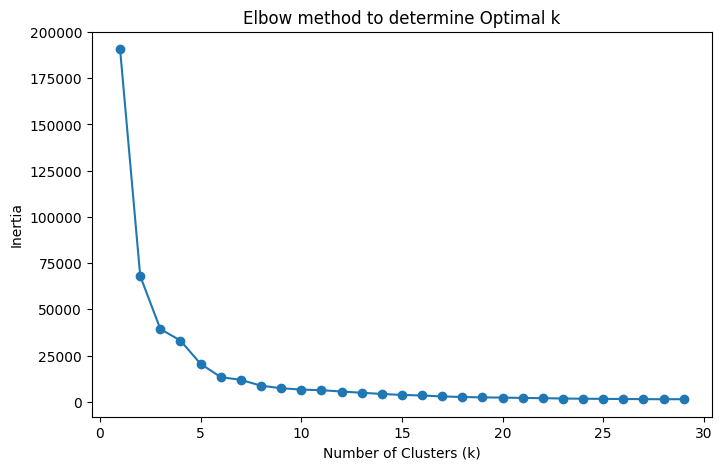

Optimal k : 6


In [15]:
#Using Elbow method to determine Optimal k
inertia = []
k_range = range(1, 30)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init='auto')
    kmeans.fit(principal_components)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow method to determine Optimal k')
plt.show()

kneedle = KneeLocator(k_range, inertia, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow
print(f'Optimal k : {elbow_point}')

## Evaluate Clustering

In [16]:
# Training the model using Optimal k(Elbow_point)
df = df.copy()
kmeans = KMeans(n_clusters=elbow_point, random_state=42,n_init='auto')
kmeans.fit(principal_components)
joblib.dump(kmeans,'kmeans_ecommerce.pkl')
df.loc[:, 'cluster'] = kmeans.predict(principal_components)
df

,pincode,Agriculture,Appliances,BPC,Electronics,F&B,Fashion,Grocery,Health & Wellness,Home & Kitchen,Multi Category,Others,Undefined,total_orders,cluster
0,263856,0.000000,0.446789,0.513025,0.210618,9.234456,2.274875,85.610235,0.471348,1.165471,0.018606,0.029521,0.025056,403099,1
1,592961,0.000000,0.129535,0.126827,0.064993,0.115543,0.487900,98.737148,0.117800,0.209874,0.004062,0.004965,0.001354,221562,1
2,588136,0.000000,0.496763,0.847896,0.236457,72.982504,2.554345,20.691510,0.590128,1.382208,0.182163,0.025878,0.010148,197076,5
3,919336,0.001344,0.931189,1.182462,0.487766,49.773585,5.216941,38.597976,1.011139,2.650462,0.049045,0.054420,0.043670,148842,2
4,294347,0.000000,0.473075,0.820798,0.200907,57.399203,3.096882,35.344976,0.613023,1.744625,0.261007,0.018030,0.027474,116472,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,609726,0.000000,2.043040,2.402615,0.915282,69.125579,9.169164,9.267230,1.765187,5.088532,0.103514,0.087170,0.032689,18355,5
140,313306,0.000000,0.404526,0.634122,0.235063,20.543377,3.083147,72.322746,0.453725,2.279560,0.021866,0.021866,0.000000,18293,3
141,973109,0.000000,0.936012,1.138541,0.470743,29.032788,4.280475,60.966665,0.738957,2.238765,0.076633,0.098528,0.021895,18269,3
142,661910,0.126186,4.822516,6.814067,2.084819,3.818511,19.388819,46.913919,4.147693,11.499424,0.148132,0.230427,0.005486,18227,3


In [17]:
avg_silhouette = silhouette_score(principal_components, df['cluster'])
avg_silhouette

0.4920746142878147

In [18]:
cluster_df = df.groupby('cluster')[df.columns[1:-1]].mean()
cluster_df 

,Agriculture,Appliances,BPC,Electronics,F&B,Fashion,Grocery,Health & Wellness,Home & Kitchen,Multi Category,Others,Undefined,total_orders
cluster,,,,,,,,,,,,,
0,0.000000,0.779334,0.964135,0.347458,86.616350,4.134111,3.889613,0.971192,2.159215,0.081113,0.034232,0.023245,41743.947368
1,0.000000,0.554985,0.637999,0.256799,7.699506,2.808589,85.968383,0.550890,1.369772,0.106973,0.037023,0.009082,120572.142857
2,0.000124,1.538811,1.671332,0.708276,49.698380,6.532387,34.637446,1.387583,3.563451,0.144956,0.083476,0.033777,37892.939394
3,0.006191,1.423763,1.715613,0.664767,23.925746,6.450498,60.388965,1.407813,3.682857,0.235393,0.076019,0.022376,31538.173913
4,0.000000,7.938959,9.769253,2.377054,10.431000,34.542645,3.721528,7.710850,23.121841,0.080534,0.282030,0.024305,19483.000000
5,0.000000,1.103475,1.448739,0.504890,70.470970,5.542653,16.487769,1.196972,3.031605,0.112446,0.075649,0.024833,35808.564103


In [19]:
df.groupby('cluster')['Agriculture'].count()

cluster
0    38
1     7
2    33
3    23
4     4
5    39
Name: Agriculture, dtype: int64

In [20]:
# Category Dominance

for cluster in cluster_df.index:
    max_value = cluster_df.iloc[:,0:-1].loc[cluster].max() 
    dominant_category = cluster_df.iloc[:,0:-1].loc[cluster].idxmax()
    if max_value >= 50:
        print(f'In cluster {cluster}, dominant category is {dominant_category}, with an average {round(max_value,2)} %')
    else:
        print(f'In cluster {cluster}, major category is {dominant_category}, with an average {round(max_value,2)} %')

In cluster 0, dominant category is F&B, with an average 86.62 %
In cluster 1, dominant category is Grocery, with an average 85.97 %
In cluster 2, major category is F&B, with an average 49.7 %
In cluster 3, dominant category is Grocery, with an average 60.39 %
In cluster 4, major category is Fashion, with an average 34.54 %
In cluster 5, dominant category is F&B, with an average 70.47 %


## Geographical Affinity

In [21]:
# geolocator = Nominatim(user_agent="geoapiExercises")
# def get_lat_lon(pin_code):
#     try:
#         location = geolocator.geocode(f"{pin_code}, India")
#         if location:
#             return (location.latitude, location.longitude)
#         else:
#             return (None, None)
#     except Exception as e:
#         print(f"Error geocoding pin code {pin_code}: {e}")
#         return (None, None)

# df[['latitude', 'longitude']] = df['pincode'].apply(lambda pin: pd.Series(get_lat_lon(pin)))
# df

In [22]:
df['region_number'] = df['pincode'].astype(str).str[0].astype(int)
df

,pincode,Agriculture,Appliances,BPC,Electronics,F&B,Fashion,Grocery,Health & Wellness,Home & Kitchen,Multi Category,Others,Undefined,total_orders,cluster,region_number
0,263856,0.000000,0.446789,0.513025,0.210618,9.234456,2.274875,85.610235,0.471348,1.165471,0.018606,0.029521,0.025056,403099,1,2
1,592961,0.000000,0.129535,0.126827,0.064993,0.115543,0.487900,98.737148,0.117800,0.209874,0.004062,0.004965,0.001354,221562,1,5
2,588136,0.000000,0.496763,0.847896,0.236457,72.982504,2.554345,20.691510,0.590128,1.382208,0.182163,0.025878,0.010148,197076,5,5
3,919336,0.001344,0.931189,1.182462,0.487766,49.773585,5.216941,38.597976,1.011139,2.650462,0.049045,0.054420,0.043670,148842,2,9
4,294347,0.000000,0.473075,0.820798,0.200907,57.399203,3.096882,35.344976,0.613023,1.744625,0.261007,0.018030,0.027474,116472,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,609726,0.000000,2.043040,2.402615,0.915282,69.125579,9.169164,9.267230,1.765187,5.088532,0.103514,0.087170,0.032689,18355,5,6
140,313306,0.000000,0.404526,0.634122,0.235063,20.543377,3.083147,72.322746,0.453725,2.279560,0.021866,0.021866,0.000000,18293,3,3
141,973109,0.000000,0.936012,1.138541,0.470743,29.032788,4.280475,60.966665,0.738957,2.238765,0.076633,0.098528,0.021895,18269,3,9
142,661910,0.126186,4.822516,6.814067,2.084819,3.818511,19.388819,46.913919,4.147693,11.499424,0.148132,0.230427,0.005486,18227,3,6


In [23]:
#Check the dominat regions in each cluster
    
count_df = df.groupby(['cluster', 'region_number']).size().reset_index(name='region_count')
max_count_df = count_df.loc[count_df.groupby('cluster')['region_number'].idxmax()]
max_count_df.reset_index(inplace = True, drop=True)
max_count_df['total_pincodes'] = df.groupby('cluster').count()['pincode']
print(max_count_df)
print('\n')
for index, row in max_count_df.iterrows():
    print(f"In cluster {row['cluster']}, region {row['region_number']} has the maximum occurences")

   cluster  region_number  region_count  total_pincodes
0        0              9             4              38
1        1              6             1               7
2        2              9             8              33
3        3              9             4              23
4        4              9             1               4
5        5              9             5              39


In cluster 0, region 9 has the maximum occurences
In cluster 1, region 6 has the maximum occurences
In cluster 2, region 9 has the maximum occurences
In cluster 3, region 9 has the maximum occurences
In cluster 4, region 9 has the maximum occurences
In cluster 5, region 9 has the maximum occurences


## Region data

1 - Northern Region

Includes states like Delhi, Haryana, Punjab, Himachal Pradesh, and Jammu & Kashmir.

2 - Western Region

Includes states like Rajasthan and Gujarat.

3 - Southern Region

Includes states like Maharashtra and parts of Madhya Pradesh.

4 - Central Region

Includes states like Uttar Pradesh and parts of Madhya Pradesh.

5 - Eastern Region

Includes states like Bihar, Jharkhand, and West Bengal.

6 - North-Eastern Region

Includes states like Assam, Arunachal Pradesh, Nagaland, and others in the northeast.

7 - Southern Region

Includes states like Andhra Pradesh, Telangana, and parts of Tamil Nadu.

8 - Southern Region

Includes states like Tamil Nadu and parts of Karnataka.

9 - The Army Postal Service (APS) and other specialized regions.

## Visualize the results

<function matplotlib.pyplot.show(close=None, block=None)>

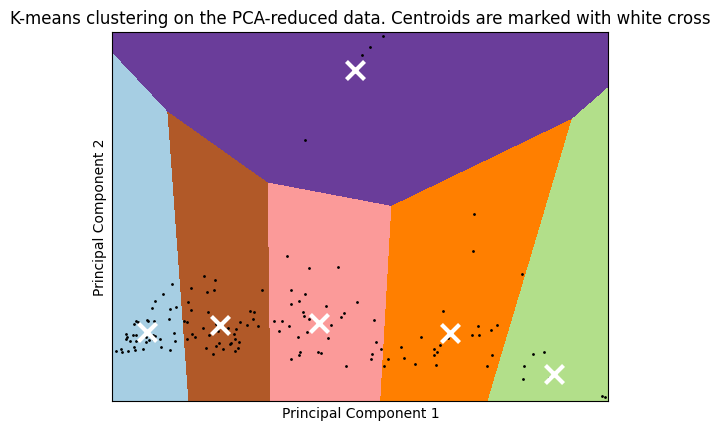

In [24]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = principal_components[:, 0].min() - 1, principal_components[:, 0].max() + 1
y_min, y_max = principal_components[:, 1].min() - 1, principal_components[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(principal_components[:, 0], principal_components[:, 1], "k.", markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the PCA-reduced data"
    ". Centroids are marked with white cross"
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show

## EXPLAINING THE APPROACH

Step 1:Importing libraries
Importing the neccessary libraries.

Step2:Data Exploration
Creating dataframe from the given excel file.
Replacing encypted pincode column with valid 6 digit unique numeric pincodes by creating a custom function.
Using df.info() to check the count of number of rows,columns, non-null entries and features datatype.

Step3:Data Cleaning & Prepossesing
using dataframe.isnull().sum() to check for the null values in dataframe.
Plotting heatmap  to visulize the positions of the null values in the dataframe.
Since the sum of each rows is 100, imputing null values in agriculture with 0.
Removing those rows where 'Multi Category' & 'Undefined' are None.
Imputing the remaining Null values in the 'Undefined' and 'Multi Category' with the difference between 100% and the sum of the other known values in that row.
checking if there any remaing null values. There are no null values remiaing.
checking if the sum in each row is 100
Summary statistics of the cleaned dataframe.
Checking for collinearity in categories features. The features appear to be highly collinear.
Since there is an inherent mullticollinearity, using PCA to address it. Deriving the pricipal compnonents from the features.

Step4: Model Training
Using Elbow method to determine Optimal clusters k, the optimal number of cluster are 6.

Step5: Training & Evaluating Clusstering
Training and saving the model using Optimal k(derived by Elbow_point method).
Evalauating the average silhouttee score of the clustering. The average score is 0.48 which is a decent score.
Checking the dominant category in each cluster by derving the mean of each categorical feature in each cluster.

Step6 : Geographical Affinity
Creating a new feature 'region' by extracting the first digit from the pincode. The first digit represent the region to which the pincode belongs to.
Checking the dominat regions in each cluster by identfying the region with maximum occurance in each cluster.